In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.backend import learning_phase
from keras.utils.generic_utils import Progbar

import conv_model
import data_utils
import sampler_utils

Using TensorFlow backend.


## Config

In [2]:
input_size = 40
dataset_path = 'top_dataset.h5'
batch_size = 64
num_val_step = 10

## Main Graph

In [3]:
model = conv_model.build()

input_data = tf.placeholder(tf.float32, (None, input_size, input_size, 2), name='input_data')
output_true = tf.placeholder(tf.float32, (None, input_size, input_size, 1), name='output_true')

with tf.variable_scope('topopt_model'):
    output_pred = model(input_data)

# metrics
correct_prediction = tf.equal(tf.round(output_true), tf.round(output_pred))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Experimental setup

In [4]:
experiments = {
    'uniform': {'model_path': './trained_models/uniform/VOL_COEFF=1.0'},
    'poisson 5': {'model_path': './trained_models/poisson_5/VOL_COEFF=1.0'},
    'poisson 10': {'model_path': './trained_models/poisson_10/VOL_COEFF=1.0'},
    'poisson 30': {'model_path': './trained_models/poisson_30/VOL_COEFF=1.0'},
}

iterations = range(5, 85, 5)

## Experiments

In [5]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()

In [6]:
for exp in experiments.values():
    saver.restore(sess, exp['model_path'])
    results = []
    
    progress = Progbar(max(iterations))
    
    for stop_iter in iterations:
        progress.update(stop_iter)
        total_val_steps = 0
        current_results = []
        
        for x, y in data_utils.DatasetIterator(dataset_path, batch_size, lambda: stop_iter):
            if total_val_steps >= num_val_step:
                break
                
            feed_dict = {input_data: x, output_true: y, learning_phase(): 0}
            current_accuracy = sess.run(accuracy, feed_dict=feed_dict)
            current_results.append(current_accuracy)
            total_val_steps += 1
            
        results.append(np.mean(current_results))
        
    exp['results'] = results

INFO:tensorflow:Restoring parameters from ./trained_models/uniform/VOL_COEFF=1.0
80/80 [==============================] - 38s 472ms/step
INFO:tensorflow:Restoring parameters from ./trained_models/poisson_5/VOL_COEFF=1.0
80/80 [==============================] - 40s 495ms/step
INFO:tensorflow:Restoring parameters from ./trained_models/poisson_10/VOL_COEFF=1.0
80/80 [==============================] - 38s 476ms/step
INFO:tensorflow:Restoring parameters from ./trained_models/poisson_30/VOL_COEFF=1.0
80/80 [==============================] - 38s 471ms/step


In [7]:
results = []
progress = Progbar(max(iterations))

for stop_iter in iterations:
    progress.update(stop_iter)
    total_val_steps = 0
    current_results = []

    for x, y in data_utils.DatasetIterator(dataset_path, batch_size, lambda: stop_iter):
        if total_val_steps >= num_val_step:
            break

        y_pred = x[:, :, :, [0]] > 0.5
        current_accuracy = np.mean(y_pred == y)
        current_results.append(current_accuracy)
        total_val_steps += 1
        
    results.append(np.mean(current_results))
    
experiments['thresholding'] = {'results': results}

80/80 [==============================] - 37s 460ms/step


## Results

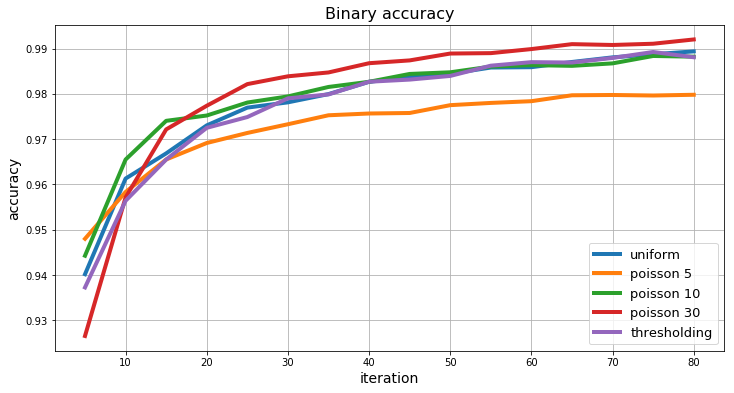

In [8]:
plt.figure(figsize=(12, 6))

for k, v in experiments.items():
    plt.plot(iterations, v['results'], label=k, lw=4)
    
plt.title('Binary accuracy', fontsize=16)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.legend(loc='best', fontsize=13)
plt.grid()
plt.show()